Epoch 1/500


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 16432.0430 - val_loss: 10463.9434
Epoch 2/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9261.4033 - val_loss: 7847.1216
Epoch 3/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4638.5884 - val_loss: 6597.4229
Epoch 4/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4978.9341 - val_loss: 6179.2886
Epoch 5/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4062.5498 - val_loss: 5652.3413
Epoch 6/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5062.8960 - val_loss: 5529.0063
Epoch 7/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2565.2256 - val_loss: 5144.8110
Epoch 8/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2297.9546 - val_loss: 5011.1719
Epoch 9/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2607.0906 - val_loss: 4923.9263
Epoch 10/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4058.2642 - val_loss: 4753.3481
Epoch 11/500
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2990.4709 - val_l

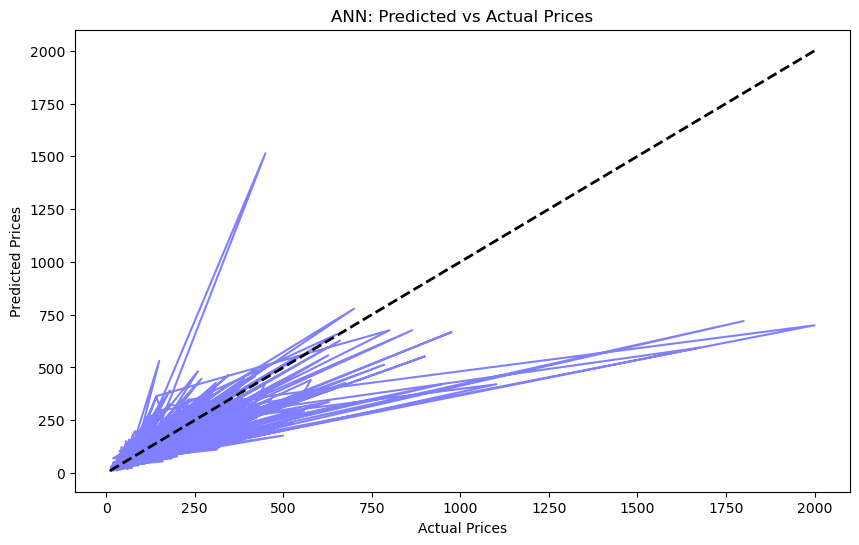

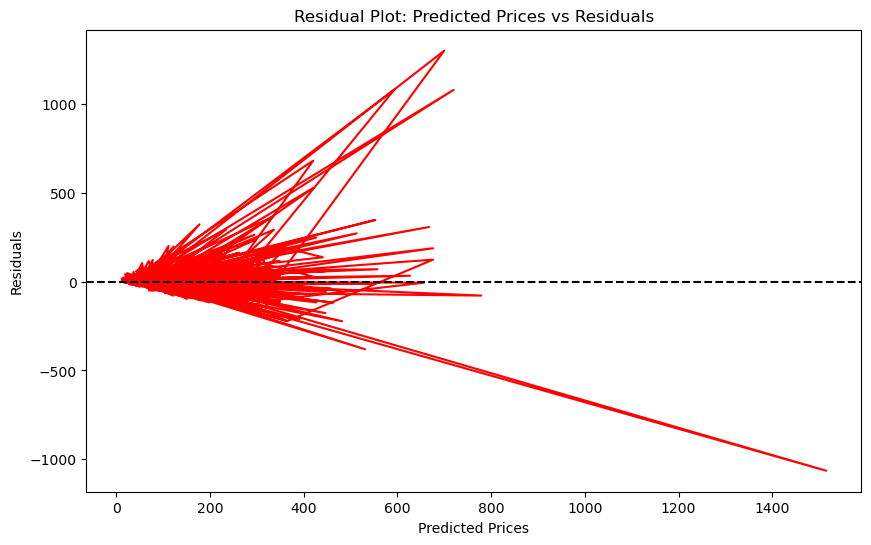

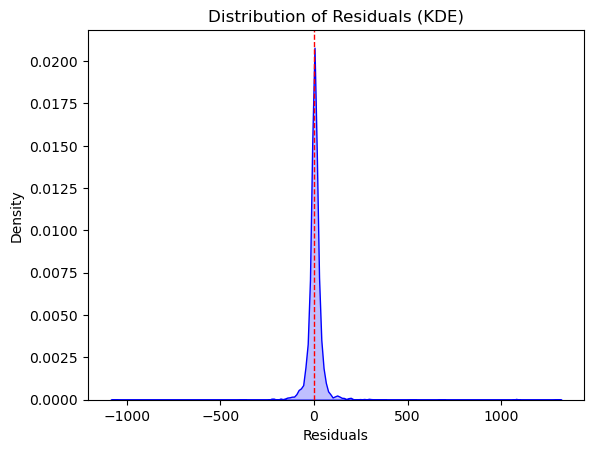

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted price for Yelahanka: 101.63128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted price for Rajkot: 159.42274


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the dataset
data = pd.read_csv("House_Data.csv")
data = data.dropna()

# Data preprocessing
data['bhk'] = data['size'].apply(lambda x: int(x.split(' ')[0]))

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)
data = data[data['total_sqft'].notnull()]

In [ ]:
# Handle outliers
data['price_sqft'] = data['price']*100000 / data['total_sqft']
upper_limit = data['price_sqft'].mean() + 3*data['price_sqft'].std()
lower_limit = data['price_sqft'].mean() - 3*data['price_sqft'].std()
data = data[(data['price_sqft'] < upper_limit) & (data['price_sqft'] > lower_limit)]

# One hot encoding for categorical variables
data = pd.get_dummies(data, columns=['location', 'area_type'], drop_first=True)

# Define dependent and independent variables
X = data.drop(['price', 'price_sqft', 'size', 'availability', 'society'], axis=1)
y = data['price']

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [ ]:
# Build the ANN model
model = Sequential()
model.add(Dense(256, input_dim=x_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile the model with Adam optimizer and early stopping
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(x_train_scaled, y_train, epochs=500, batch_size=32, validation_data=(x_test_scaled, y_test), callbacks=[early_stop], verbose=1)

# Predict on test data
y_pred_ann = model.predict(x_test_scaled)

# Calculate evaluation metrics
mse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
rmse_ann = np.sqrt(mse_ann)
mae_ann = mean_absolute_error(y_test, y_pred_ann)

In [ ]:
# Print metrics
print(f"ANN MAE: {mae_ann}")
print(f"ANN MSE: {mse_ann}")
print(f"ANN RMSE: {rmse_ann}")

In [ ]:
# ---- PLOTS ----

# Visualizing Predicted vs Actual Prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_pred_ann, c='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('ANN: Predicted vs Actual Prices')
plt.show()

In [ ]:
# Residual Plot using Line Plot
residuals = y_test - y_pred_ann.flatten()
plt.figure(figsize=(10, 6))

# Using line plot for residuals
plt.plot(y_pred_ann.flatten(), residuals, color='r')  # Line plot

plt.axhline(0, linestyle='--', color='black')
plt.title('Residual Plot: Predicted Prices vs Residuals')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.show()

sns.kdeplot(residuals, color='blue', bw_adjust=0.5, fill=True)

# Add a title and labels
plt.title('Distribution of Residuals (KDE)')
plt.xlabel('Residuals')
plt.ylabel('Density')

# Add a vertical line at 0
plt.axvline(0, color='red', linestyle='--', linewidth=1)  # Line at 0 for reference

# Show the plot
plt.show()

In [ ]:
# ---- Prediction Function ----
def predict_price(location, area_type, size, bath, balcony, total_sqft):
    input_data = np.zeros(X.shape[1])
    input_data[0] = total_sqft
    input_data[1] = bath
    input_data[2] = balcony
    input_data[3] = size
    
    # Fill in one-hot encoded location
    if 'location_' + location in X.columns:
        loc_index = X.columns.get_loc('location_' + location)
        input_data[loc_index] = 1
    
    # Fill in one-hot encoded area type
    if 'area_type_' + area_type in X.columns:
        area_index = X.columns.get_loc('area_type_' + area_type)
        input_data[area_index] = 1

    # Scale input data
    input_data_scaled = scaler.transform([input_data])

    # Predict price using the trained ANN model
    predicted_price = model.predict(input_data_scaled)
    return predicted_price[0][0]


In [ ]:
# Example predictions
print("Predicted price for Yelahanka:", predict_price('Yelahanka', 'Carpet Area', 3, 3, 2, 3000))


In [ ]:
print("Predicted price for Rajkot:", predict_price('Rajkot', 'Carpet Area', 3, 3, 3, 2550))
